In [2]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import gym

from drl.ddpg import DDPG
from utils import Params, set_logger, create_experiment_folder

PATH_PROJECT = Path.cwd().parent
PATH_RESULTS = PATH_PROJECT / 'results'

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # don't use GPU
plt.style.use('seaborn')

# Set seed
np.random.seed(123)
if tf.__version__[0] == '2': # tensorflow 2
#     tf.compat.v1.disable_eager_execution() # otherwise very slow
    tf.random.set_seed(123) # needs to be after the previous line
else: # tensorflow 1
    tf.set_random_seed(123)

# Initialize

In [4]:
# read parameters
params = Params('drl/ddpg_params.json')
params.environment_name = 'LunarLanderContinuous-v2'

# create folder to save results and parameters
path_results_exp = create_experiment_folder(PATH_RESULTS, params.environment_name, params.agent_name)
params.save(path_results_exp / 'params.json')

# log files
monitor_train = pd.DataFrame(columns=['steps', 'train_reward', 'test_reward'])
monitor_train.index.name = 'train_episode'
monitor_train.to_csv(path_results_exp / 'monitor_train.csv')


# ENVIRONMENT
env = gym.make(params.environment_name)
env.seed(params.env_options['seed'])
env.reset()


# AGENT
nb_train_steps = params.training['nb_train_steps']
eval_every_n_steps = params.training['eval_every_n_steps']
nb_eval_steps = params.training['nb_eval_steps']

agent = DDPG(env, 
             neurons_per_layer=params.DDPG['neurons_per_layer'], 
             replay_memory_max_size=params.DDPG['buffer_size'], 
             discount_factor=params.DDPG['gamma'],
             L2_coeff=params.DDPG['L2_coeff'],
             LR_critic=params.DDPG['LR_critic'],
             LR_actor=params.DDPG['LR_actor'])

# Train

In [6]:
%%time
nb_train_steps = params.training['nb_train_steps']
eval_every_n_steps = params.training['eval_every_n_steps']
nb_eval_steps = params.training['nb_eval_steps']

print('Start training')
train_episode = 0
total_steps = 0
for i in range(nb_train_steps // eval_every_n_steps):
    
    # Train
    list_total_reward_train, list_steps = agent.train(env, 
                                                      nb_training_steps=eval_every_n_steps, 
                                                      minibatch_size=params.DDPG['batch_size'], 
                                                      tau_update_target=params.DDPG['tau_update_target'],
                                                      warmup_steps=params.DDPG['warmup_steps'])
    train_episodes_idx = np.arange(train_episode, train_episode+len(list_total_reward_train)) + 1
    train_episode += len(list_total_reward_train)
    steps = total_steps + np.array(list_steps)
    total_steps += eval_every_n_steps

    # Test
    list_total_reward_test = agent.test(env, nb_testing_steps=nb_eval_steps)
    average_test_reward = np.mean(list_total_reward_test)
    print('{} training episodes done ({} steps); average train reward is {:.1f} ; average test reward is {:.1f}'.format(
        train_episode, total_steps, np.mean(list_total_reward_train), average_test_reward))

    # Save results
    monitor_train = pd.DataFrame({'steps': steps,
                                  'train_reward': list_total_reward_train,
                                  'test_reward': np.nan}, index=train_episodes_idx)
    monitor_train.loc[train_episodes_idx[-1], 'test_reward'] = average_test_reward
    monitor_train.to_csv(path_results_exp / 'monitor_train.csv', mode='a', header=None)

print('Training finished')


312 training episodes done (109000 steps); average train reward is 162.1 ; average test reward is 129.7
313 training episodes done (110000 steps); average train reward is 249.5 ; average test reward is -38.4
314 training episodes done (111000 steps); average train reward is 257.6 ; average test reward is -145.6
316 training episodes done (112000 steps); average train reward is 154.0 ; average test reward is -70.2
318 training episodes done (113000 steps); average train reward is 213.0 ; average test reward is 89.5
320 training episodes done (114000 steps); average train reward is 229.4 ; average test reward is 234.3
323 training episodes done (115000 steps); average train reward is 233.6 ; average test reward is 97.3
325 training episodes done (116000 steps); average train reward is 100.1 ; average test reward is 260.4
327 training episodes done (117000 steps); average train reward is 233.2 ; average test reward is -132.1
328 training episodes done (118000 steps); average train reward

In [8]:
# Visualize agent performace
agent.test(env, nb_testing_steps=nb_eval_steps, visualize=True)
env.close()

# Display results

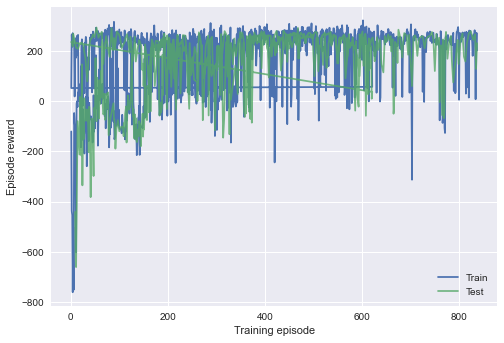

In [13]:
monitor_train = pd.read_csv(path_results_exp / 'monitor_train.csv', index_col=0)

plt.figure()
plt.plot(monitor_train.index, monitor_train['train_reward'], label='Train')
plt.plot(monitor_train.index, monitor_train['test_reward'].interpolate(), label='Test', alpha=0.8)
plt.legend()
plt.xlabel('Training episode')
plt.ylabel('Episode reward')
plt.savefig(path_results_exp / 'training_curve.png', transparent=False)

In [12]:
monitor_train

,steps,train_reward,test_reward
train_episode,,,
1,60,-121.013377,NaN
2,138,-437.191812,NaN
3,222,-453.450487,NaN
4,312,-760.646981,NaN
5,389,-502.032863,NaN
...,...,...,...
833,297934,210.223408,266.052798
834,298100,7.375143,NaN
835,298652,226.272741,128.024249
